# ShEx

This document contains a short introduction to ShEx using [rudof](https://rudof-project.github.io/).


## Preliminaries: Install and configure rudof

First, we install and configure `rudof`.

In [1]:
# @title
!pip install pyrudof
from pyrudof import Rudof, RudofConfig
rudof = Rudof(RudofConfig())

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 14.1 MB/s eta 0:00:00


## Validating RDF using ShEx

[ShEx (Shape Expressions)](https://shex.io/) is a concise and human-readable language to describe and validate RDF data.

A ShEx schema contains several declarations of shapes and can be defined in several formats: a compact format (ShExC), a JSON-LD format (ShExJ) and an RDF based on (ShExR).

Let's start defining a simple ShEx schema as:

In [2]:
rudof.read_shex_str("""
prefix :     <http://example.org/>
prefix xsd:  <http://www.w3.org/2001/XMLSchema#>

:User {
 :name      xsd:string   ;
 :birthDate xsd:date     ;
 :knows     @:User     * ;
 :worksFor  @:Company  *
}

:Company {
  :name     xsd:string    ;
  :code     xsd:integer   ;
  :employee @:User      *
}
""")

And let's define some RDF data.

In [3]:
rudof.read_data_str("""
prefix : <http://example.org/>
prefix rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
prefix xsd: <http://www.w3.org/2001/XMLSchema#>

:alice a :Person ;
 :name      "Alice"                ;
 :birthDate "2005-03-01"^^xsd:date ;
 :worksFor  :acme                  ;
 :knows     :bob                   .
:bob a :Person   ;
 :name      "Robert Smith"         ;
 :birthDate "2003-01-02"^^xsd:date ;
 :worksFor  :acme                  ;
 :knows     :alice                 .
:acme  a :Company  ;
 :name      "Acme Inc." ;
 :code      23          .
""")

In order to validate nodes in a graph, ShEx uses a [ShapeMap](https://shex.io/shape-map/), which associates a node selector with a shape.

The simplest shape map is a pair `node@shape`.

Rudof keeps the current shape map in a structure so it can be reused.

The method `read_shapemap_str(shapemap)` can be used to read a shapemap from a string and store it's value as the currrent shape map.

In the previous example, if we want to validate `:alice` as a `:Person` we can use:

In [4]:
rudof.read_shapemap_str(":alice@:User")

Once the ShEx schema and the Shapemap have been added to `rudof`, it is possible to validate the current RDF data with the `validate_shex()` method:

In [5]:
results = rudof.validate_shex()

`validate_shex()` returns a [`ResultShapeMap`](https://pyrudof.readthedocs.io/en/stable/library.html#resultshapemap) object which contains a `show_as_table()` method to show the results of the validation.

In [6]:
print(results.show_as_table())

╭────────┬───────┬────────╮
│ Node   │ Shape │ Status │
├────────┼───────┼────────┤
│ :alice │ :User │ OK     │
╰────────┴───────┴────────╯



If we want to validate `:acme` as a `:Person`, we could do:

In [7]:
rudof.read_shapemap_str(":alice@:Company")
results = rudof.validate_shex()
print(results.show_as_table())

╭────────┬──────────┬────────╮
│ Node   │ Shape    │ Status │
├────────┼──────────┼────────┤
│ :alice │ :Company │ FAIL   │
╰────────┴──────────┴────────╯



It is possible to know more details about the reason for failing with the `with_details=True` parameter.

In [8]:
print(results.show_as_table(with_details=True))

╭────────┬──────────┬────────┬─────────────────────────────────────────────────────────────────────╮
│ Node   │ Shape    │ Status │ Details                                                             │
├────────┼──────────┼────────┼─────────────────────────────────────────────────────────────────────┤
│ :alice │ :Company │ FAIL   │ Error Shape 1 failed for node http://example.org/alice with errors  │
│        │          │        │                                                                     │
╰────────┴──────────┴────────┴─────────────────────────────────────────────────────────────────────╯



The shapemap can contain a list of nodes and shapes, so it is possible to run several validations like:

In [9]:
rudof.read_shapemap_str(":alice@:User, :bob@:User")
results = rudof.validate_shex()
print(results.show_as_table())

╭────────┬───────┬────────╮
│ Node   │ Shape │ Status │
├────────┼───────┼────────┤
│ :alice │ :User │ OK     │
├────────┼───────┼────────┤
│ :bob   │ :User │ OK     │
╰────────┴───────┴────────╯



Sometimes, it is necessary to get the list of results in Python to process them. The [ResultShapeMap](https://pyrudof.readthedocs.io/en/latest/library.html#resultshapemap) class contains a method `to_list()` which returns a tuple of `(node, shape, status)`.

In [10]:
for (node, shape, status) in results.to_list():
    print(f"Node: {node.show()}")
    print(f"Shape: {shape.show()}")
    print(f"Conformant?: {status.is_conformant()}")
    print(f"Appinfo: {status.as_json()}")
    print("")


Node: http://example.org/alice
Shape: http://example.org/User
Conformant?: True
Appinfo: {'info': [{'reason': 'Shape passed. Node http://example.org/alice, shape 0: Shape  Preds: http://example.org/name,http://example.org/birthDate,http://example.org/knows,http://example.org/worksFor, TripleExpr: RBE [C0;C1;C2*;C3*;], Keys: [http://example.org/name -> {C0}, http://example.org/birthDate -> {C1}, http://example.org/knows -> {C2}, http://example.org/worksFor -> {C3}], conds: [C0 -> xsd:string, C1 -> xsd:date, C2 -> @0, C3 -> @1], References: [http://example.org/knows->0, http://example.org/worksFor->1]'}], 'reason': 'Shape passed. Node :alice, shape 0: :User = {(:name xsd:string ; :birthDate xsd:date ; :knows @0* ; :worksFor @1* ; )}\n', 'status': 'conformant'}

Node: http://example.org/bob
Shape: http://example.org/User
Conformant?: True
Appinfo: {'info': [{'reason': 'Shape passed. Node http://example.org/bob, shape 0: Shape  Preds: http://example.org/name,http://example.org/birthDate,ht

We reset the status of the `ShEx` schema, the `Shapemap` and the current `RDF data` for the next section.

In [13]:
# @title
rudof = Rudof(RudofConfig())


## Validating SPARQL endpoints

It is also possible to validate RDF data which is not local but is available in a SPARQL endpoint like wikidata or dbpedia. Let's start with Wikidata:

In [14]:
rudof.use_endpoint("wikidata")

We can declare a simple shape in Wikidata as follows:

In [15]:
rudof.read_shex_str("""
prefix : <http://example.org/>
prefix wd: <http://www.wikidata.org/entity/>
prefix wdt: <http://www.wikidata.org/prop/direct/>

:Researcher {
  wdt:P31 [ wd:Q5 ] ; # Instance of Human
  wdt:P19 @:Place   ; # BirthPlace
}
:Place {
  wdt:P17 @:Country * ; # Country
}
:Country {}
""")

In [16]:
rudof.read_shapemap_str("wd:Q80@:Researcher")

In [17]:
results = rudof.validate_shex()

In [18]:
print(results.show_as_table(with_details=True))

╭────────────────────────────────────┬─────────────┬────────┬──────────────────────────────────────────────────────────────────────────────────╮
│ Node                               │ Shape       │ Status │ Details                                                                          │
├────────────────────────────────────┼─────────────┼────────┼──────────────────────────────────────────────────────────────────────────────────┤
│ http://www.wikidata.org/entity/Q80 │ :Researcher │ OK     │ Shape passed. Node http://www.wikidata.org/entity/Q80, shape 0: :Researcher = {( │
│                                    │             │        │ wdt:P31 [wd:Q5 ] ; wdt:P19 @1 ; )}                                               │
│                                    │             │        │                                                                                  │
╰────────────────────────────────────┴─────────────┴────────┴─────────────────────────────────────────────────────────────────────

## Visualizing ShEx schemas

`rudof` can be used to convert ShEx to diagrams in UML-like style. The converter generates a [PlantUML](https://plantuml.com/) string which can be written to a file and converted to an image using the PlantUML tool.

In [19]:
from pyrudof import UmlGenerationMode

In [20]:
rudof.read_shex_str("""
prefix : <http://example.org/>
prefix xsd:    <http://www.w3.org/2001/XMLSchema#>

:User {
 :name     xsd:string  ;
 :worksFor @:Company * ;
 :addres   @:Address   ;
 :knows    @:User
}

:Company {
  :name     xsd:string     ;
  :code     xsd:string     ;
  :employee @:User
}
:Address {
  :name     xsd:string ;
  :zip_code xsd:string
}
""")

In [21]:
plant_uml = rudof.shex2plantuml_file(UmlGenerationMode(), 'out.puml')

Now we install the PlantUML tools necessary to process the generated `plant_uml`

In [22]:
# @title
! pip install plantuml
! pip install ipython
!python -m plantuml out.puml
from IPython.display import Image

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 32.8 MB/s eta 0:00:00
[{'filename': 'out.puml', 'gen_success': True}]


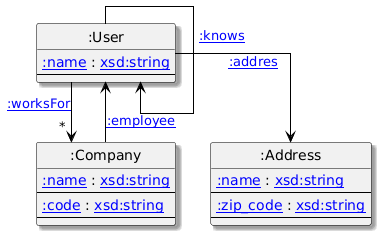

In [23]:
Image(f"out.png")